In [92]:
#import packages
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

# Part 1: Data Exploration

In [93]:
insurance = pd.read_csv("https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1")
insurance

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,33,male,22.705,no,northwest,21984.47061
2,32,male,28.880,no,northwest,3866.85520
3,31,female,25.740,no,southeast,3756.62160
4,60,female,25.840,no,northwest,28923.13692
...,...,...,...,...,...,...
426,23,female,33.400,no,southwest,10795.93733
427,18,female,31.920,no,northeast,2205.98080
428,18,female,36.850,no,southeast,1629.83350
429,21,female,25.800,no,southwest,2007.94500


In [94]:
#check data types for each column
insurance.dtypes

age          int64
sex         object
bmi        float64
smoker      object
region      object
charges    float64
dtype: object

In [95]:
#count how many males and females
insurance["sex"].value_counts()

female    225
male      206
Name: sex, dtype: int64

In [96]:
#average insurance charges based on sex
insurance[["sex", "charges"]].groupby("sex").mean()

,charges
sex,
female,11919.373162
male,12709.661784


On average, men are charged more for insurance than women.

In [97]:
#average insurance charges based on smoker
insurance[["smoker", "charges"]].groupby("smoker").mean()

,charges
smoker,
no,7528.467642
yes,31152.372644


Smokers are billed more for insurance than for non-smokers.

In [98]:
#average insurance charges based on region
insurance[["region", "charges"]].groupby("region").mean().sort_values(by = "charges", ascending = False)

,charges
region,
southeast,13916.786760
northeast,11985.217747
southwest,11765.159818
northwest,11097.220696


People living in the southeast region are billed the most in medical costs by health insurances. People living in the northwest region are billed the least in medical costs.

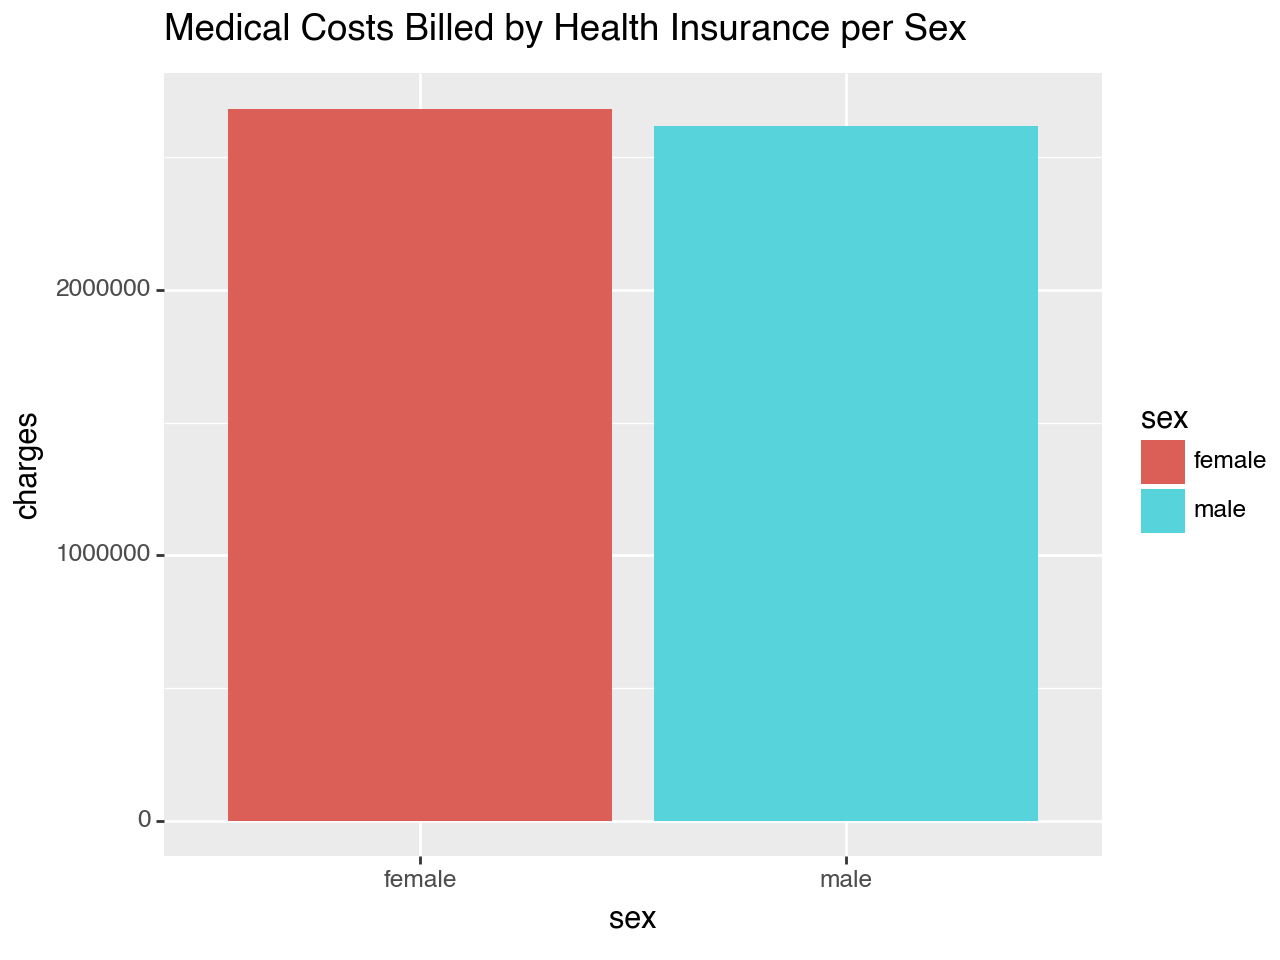

<Figure Size: (640 x 480)>

In [99]:
#plot 1: sex v/s charges
(ggplot(insurance, aes(x = "sex", y = "charges", fill = "sex"))
 + geom_col()
 + ggtitle("Medical Costs Billed by Health Insurance per Sex")
)

From this graph, we can say that females pay slightly more in medical bills than males. However, we also must keep in mind that there are more females than males in the data set. 

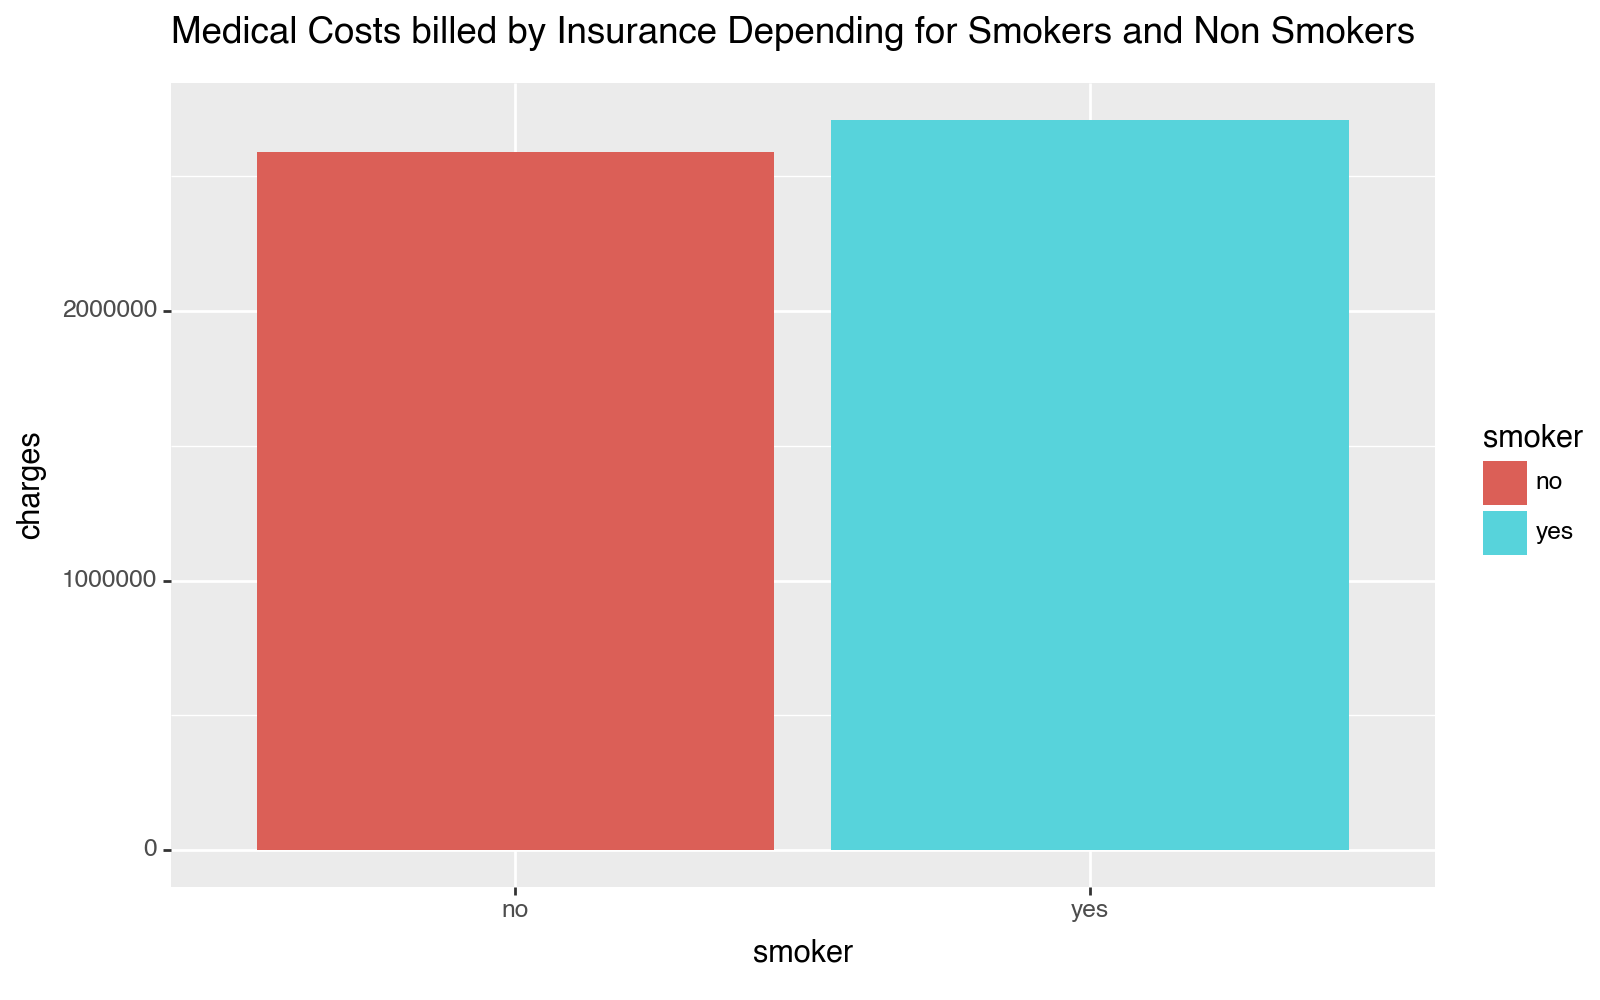

<Figure Size: (800 x 500)>

In [100]:
#plot 2: smoker v/s charges
(ggplot(insurance, aes(x = "smoker", y = "charges", fill = "smoker"))
 + geom_col()
 + ggtitle("Medical Costs billed by Insurance Depending for Smokers and Non Smokers")
 + theme(figure_size = (8, 5))
)

This plot shows that smokers pay more in medical costs billed by insurances than nonsmokers. This matches the summary statistic created above.

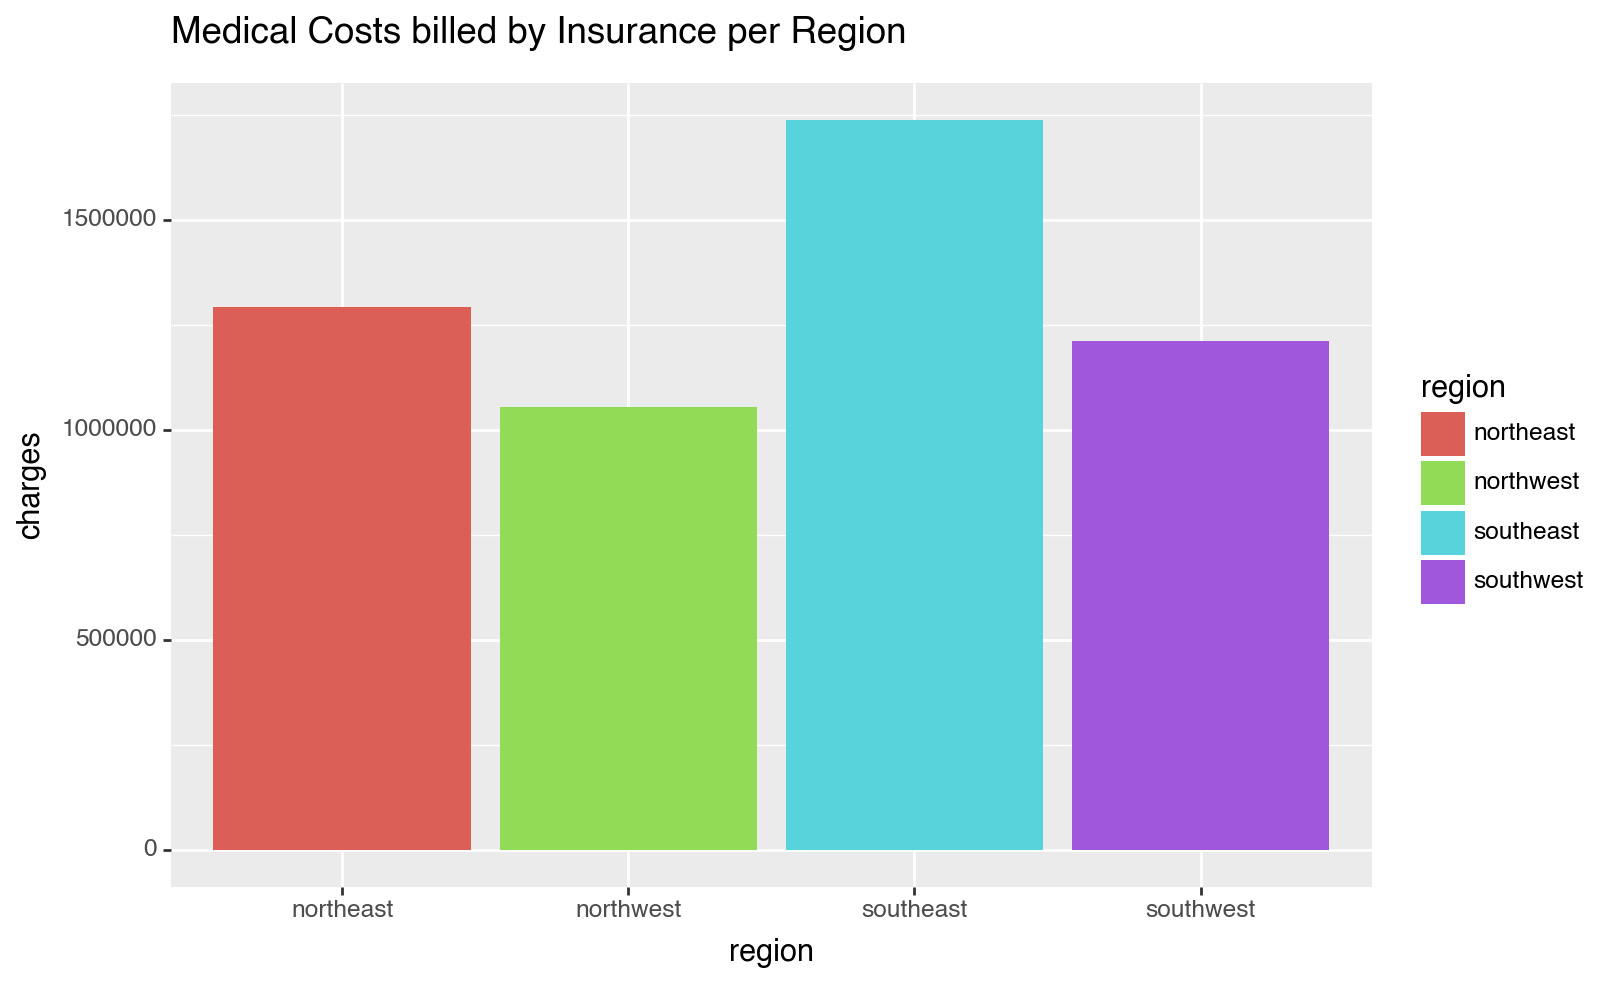

<Figure Size: (800 x 500)>

In [101]:
#plot 3: region v/s charges
(ggplot(insurance, aes(x = "region", y = "charges", fill = "region"))
 + geom_col()
 + ggtitle("Medical Costs billed by Insurance per Region")
 + theme(figure_size = (8, 5))
)

This plot shows that the southeast region pays the most in medical costs billed by insurances. This matches the summary statistic created above.

# Part 2: Simple Linear Models

### model 1: predict insurance charges from beneficiary's age

In [102]:
X = insurance[["age"]] #2D data frame
y = insurance["charges"] #1D just one column of ur y
X_train, X_test, y_train, y_test = train_test_split(X,y)

lr = LinearRegression() #make linear regression function

my_pipeline = Pipeline(
    [('ols', lr)] 
) 

fitted_my_pipeline = my_pipeline.fit(X_train, y_train)
fitted_my_pipeline

y_preds = fitted_my_pipeline.predict(X_test)


In [103]:
#coefficient estimate of fitted pipeline
fitted_my_pipeline.named_steps['ols'].coef_

array([211.62345508])

In [104]:
#R^2 value
model1_r2 = r2_score(y_test, y_preds)
model1_r2

0.12471952202116687

In [105]:
#mean square error
model1_mse = mean_squared_error(y_test, y_preds)
model1_mse

109475341.63018309

In [106]:
#fit the model
predictions = pd.DataFrame({"X test age": X_test["age"],
                            "y test charges": y_test,
                            "y preds charges": y_preds})
predictions

,X test age,y test charges,y preds charges
109,19,1635.73365,8570.468540
74,42,19515.54160,13437.808006
64,19,2130.67590,8570.468540
315,45,7348.14200,14072.678372
55,24,2855.43755,9628.585815
...,...,...,...
351,21,1909.52745,8993.715450
421,19,1731.67700,8570.468540
144,18,1149.39590,8358.845084
41,20,2257.47525,8782.091995


### Interpreting Results
Coefficient: For every year increase in age, medical costs billed by insurances increase by about $211. The mean square error is very high, and the R^2 value is very low (almost close to 0). We need to find a better model.

### Model 2: incorporates sex

In [170]:
X2 = insurance[["age","sex"]]
y2 = insurance["charges"] 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2)

lr = LinearRegression() #make linear regression function
enc = OneHotEncoder(drop = "first") #drop one of the dummy variables to use as reference (source: chatgpt)
#the one that is dropped is female, since it appeared first in the pandas dataframe

ct = ColumnTransformer(
    [("dummify_sex", enc, ["sex"])], remainder = "passthrough" #keep other columns untouched 
)

my_pipeline2 = Pipeline(
    [("dummify_everything", ct), ('ols', lr)] 
) 

In [108]:
fitted_my_pipeline2 = my_pipeline2.fit(X_train2, y_train2)

y_preds2 = fitted_my_pipeline2.predict(X_test2)

In [109]:
#R^2 value
model2_r2 = r2_score(y_test2, y_preds2)
model2_r2

0.009469792697730517

In [110]:
predictions2 = pd.DataFrame({"X test sex": X_test2["sex"],
                             "X test age": X_test2["age"],
                            "y test charges": y_test2,
                            "y preds charges": y_preds2})
predictions2

,X test sex,X test age,y test charges,y preds charges
220,female,58,12430.95335,16497.272368
260,female,62,13457.96080,17505.835544
159,male,23,1824.28540,8673.929739
189,male,63,13390.55900,18759.561507
78,female,18,1615.76670,6411.640599
...,...,...,...,...
125,female,58,11856.41150,16497.272368
4,female,60,28923.13692,17001.553956
194,male,27,2494.02200,9682.492916
195,female,19,2128.43105,6663.781393


In [111]:
#coefficient estimates
fitted_my_pipeline2.named_steps['ols'].coef_

array([1001.58516875,  252.14079422])

In [112]:
#mean square error
model2_mse = mean_squared_error(y_test2, y_preds2)
model2_mse

167312868.63161045

### Interpreting Results
Coefficient: A male patient is associated with a 1001.59 dollars increase in medical costs billed by insurances. For every year increase in age, medical costs billed by insurances increase by $252.14. The mean square error is lower than the mean square error with the model only using age, but the R^2 value is still very low.

### model 3: does not include sex but does include smoker

In [113]:
X3 = insurance[["age", "smoker"]]
y3 = insurance["charges"]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3)

lr = LinearRegression() 
enc = OneHotEncoder(drop = "first")

ct_smoker = ColumnTransformer(
    [("dummify_smoker", enc, ["smoker"])], remainder = "passthrough"
)

my_pipeline3 = Pipeline(
    [("dummify_everything", ct_smoker), ('ols', lr)] 
) 

In [114]:
fitted_my_pipeline3 = my_pipeline3.fit(X_train3, y_train3)

y_preds3 = fitted_my_pipeline3.predict(X_test3)

In [115]:
#R^2 value
model3_r2 = r2_score(y_test3, y_preds3)
model3_r2

0.7315396722696988

In [116]:
#Mean squared error
model3_mse = mean_squared_error(y_test3, y_preds3)
model3_mse

33086497.373081252

In [117]:
#coefficient estimates - it is in alphabetical order
fitted_my_pipeline3.named_steps['ols'].coef_

array([23871.32531262,   256.55484157])

### Interpreting results
Coefficient: Holding age constant, non-smokers are associated with an increase in 23871.33 dollars. For every year increase in age, medical costs billed increase by $256.55.
The mean square error is smaller than the previous model, and the R^2 is a lot higher than the previous model. This is a better model.

In [118]:
#looking at R^2 and MSE
models = [1, 2, 3]
r2 = [model1_r2, model2_r2, model3_r2]
mse = [model1_mse, model2_mse, model3_mse]

values = pd.DataFrame({"model_num": models,
                       "R^2 value": r2,
                       "Mean Squared Error": mse})
values

,model_num,R^2 value,Mean Squared Error
0,1,0.12472,1.094753e+08
1,2,0.00947,1.673129e+08
2,3,0.73154,3.308650e+07


In [119]:
values[["model_num", "R^2 value"]].sort_values(by = "R^2 value", ascending = False)

,model_num,R^2 value
2,3,0.73154
0,1,0.12472
1,2,0.00947


In [120]:
values[["model_num", "Mean Squared Error"]].sort_values(by = "Mean Squared Error", ascending = True)

,model_num,Mean Squared Error
2,3,3.308650e+07
0,1,1.094753e+08
1,2,1.673129e+08


Comparing the R^2 and mean squared error values between each model, we can say that the third model with age and smoker as the explanatory variables is the best model. It has the highest R^2 value and the lowest mean square error value.

# Part 3: Multiple Linear Models

### model 4: uses age and bmi as predictors

In [121]:
X4 = insurance[["age", "bmi"]]
y4 = insurance["charges"]
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4,y4)

lr = LinearRegression() 

my_pipeline4 = Pipeline(
    [('ols', lr)] 
) 

In [122]:
fitted_my_pipeline4 = my_pipeline4.fit(X_train4, y_train4)

y_preds4 = fitted_my_pipeline4.predict(X_test4)

In [123]:
#Mean squared error
model4_mse = mean_squared_error(y_test4, y_preds4)
model4_mse

107730533.50604814

In [124]:
#R^2 value
model4_r2 = r2_score(y_test4, y_preds4)
model4_r2

0.14701463947261906

The mean square error for model 4 smaller than the mean square error in part 2 question 1. The R^2 value for model 4 is higher than the R^2 value for the model in question 2 part 1. Model 4 is the better model so far.

### Model 5: with age and age^2

In [125]:
X5 = insurance[["age"]]
y5 = insurance["charges"]
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5,y5)

lr = LinearRegression() 
poly2 = PolynomialFeatures(2, include_bias = False, interaction_only = False)

ct2 = ColumnTransformer(
    [("quadratic", poly2, ["age"])]
)

my_pipeline5 = Pipeline(
    [("age_squared", ct2),('ols', lr)] 
) 

In [126]:
fitted_my_pipeline5 = my_pipeline5.fit(X_train5, y_train5)

y_preds5 = fitted_my_pipeline5.predict(X_test5)

In [127]:
#Mean squared error
model5_mse = mean_squared_error(y_test5, y_preds5)
model5_mse

163343191.53545582

In [128]:
#R^2 value
model5_r2 = r2_score(y_test5, y_preds5)
model5_r2

0.004745607222486514

The R^2 value in model 5 is lower than the R^2 value for the model in part 2 question 1. The mean square error in model 5 is also higher than the mean square error in the model for part 2 question 1. The model in P2 Q1 is better than this model.

### Model 6: Fit a polynomial model of degree of 4

In [129]:
X6 = insurance[["age"]]
y6 = insurance["charges"]
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6,y6)

lr = LinearRegression() 
poly4 = PolynomialFeatures(4)

ct4 = ColumnTransformer(
    [("fourth_power", poly4, ["age"])]
)

my_pipeline6 = Pipeline(
    [("age_fourth", ct4),('ols', lr)] 
) 

In [130]:
fitted_my_pipeline6 = my_pipeline6.fit(X_train6, y_train6)

y_preds6 = fitted_my_pipeline6.predict(X_test6)

In [131]:
#Mean squared error
model6_mse = mean_squared_error(y_test6, y_preds6)
model6_mse

130133388.48557355

In [132]:
#R^2 value
model6_r2 = r2_score(y_test6, y_preds6)
model6_r2

0.0849933620152914

The R^2 value for model 6 here is lower than the R^2 value for the model in P2 Q1. The mean square error in model 6 is also higher than the mean square error than the mean square error for P2 Q1. Model 6 is worse compared to the model in P2 Q1.

### Model 7: Fit a polynomial model of degree 12


In [133]:
X7 = insurance[["age"]]
y7 = insurance["charges"]
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7,y7)

lr = LinearRegression() 
poly12 = PolynomialFeatures(12)

ct12 = ColumnTransformer(
    [("twelfth_power", poly12, ["age"])]
)

my_pipeline7 = Pipeline(
    [("age_twelfth", ct12),('ols', lr)] 
) 

In [134]:
fitted_my_pipeline7 = my_pipeline7.fit(X_train7, y_train7)

y_preds7 = fitted_my_pipeline7.predict(X_test7)

In [135]:
#Mean squared error
model7_mse = mean_squared_error(y_test7, y_preds7)
model7_mse

128098093.72377525

In [136]:
#R^2 value
model7_r2 = r2_score(y_test7, y_preds7)
model7_r2

0.054768067768138806

This model performed worse than the model in P2 Q1. It has a higher MSE and a lower R^2.

In [137]:
#looking at R^2 and MSE
models = [1, 4, 5, 6, 7]
r2 = [model1_r2, model4_r2, model5_r2, model6_r2, model7_r2]
mse = [model1_mse, model4_mse, model5_mse, model6_mse, model7_mse]

values2 = pd.DataFrame({"model_num": models,
                       "R^2 value": r2,
                       "Mean Squared Error": mse})


In [138]:
values2[["model_num", "R^2 value"]].sort_values(["R^2 value"], ascending = False)

,model_num,R^2 value
1,4,0.147015
0,1,0.124720
3,6,0.084993
4,7,0.054768
2,5,0.004746


In [139]:
values2[["model_num", "Mean Squared Error"]].sort_values(["Mean Squared Error"], ascending = True)

,model_num,Mean Squared Error
1,4,1.077305e+08
0,1,1.094753e+08
4,7,1.280981e+08
3,6,1.301334e+08
2,5,1.633432e+08


After comparing the R^2 and MSE values, we can see that model 4 performs the best. However, this is not the "best" model possible because the R^2 is still very low and the MSE is still very large.

### plot predictions from model in Q4 as line plot on top of scatter plot of original data


In [140]:
predictions_1 = pd.DataFrame({"y_test": y_test7,
              "y_preds7": y_preds7,
              "X_test7_age": X_test7["age"]})
predictions_1


,y_test,y_preds7,X_test7_age
387,8671.19125,14751.160077,48
303,48673.55880,17334.062341,60
85,33750.29180,7560.417181,19
350,13974.45555,21202.011899,63
377,5227.98875,14517.411610,35
...,...,...,...
271,1877.92940,7493.406853,20
126,3176.81590,9038.540723,26
34,15820.69900,15284.708944,38
100,7421.19455,15074.555088,44


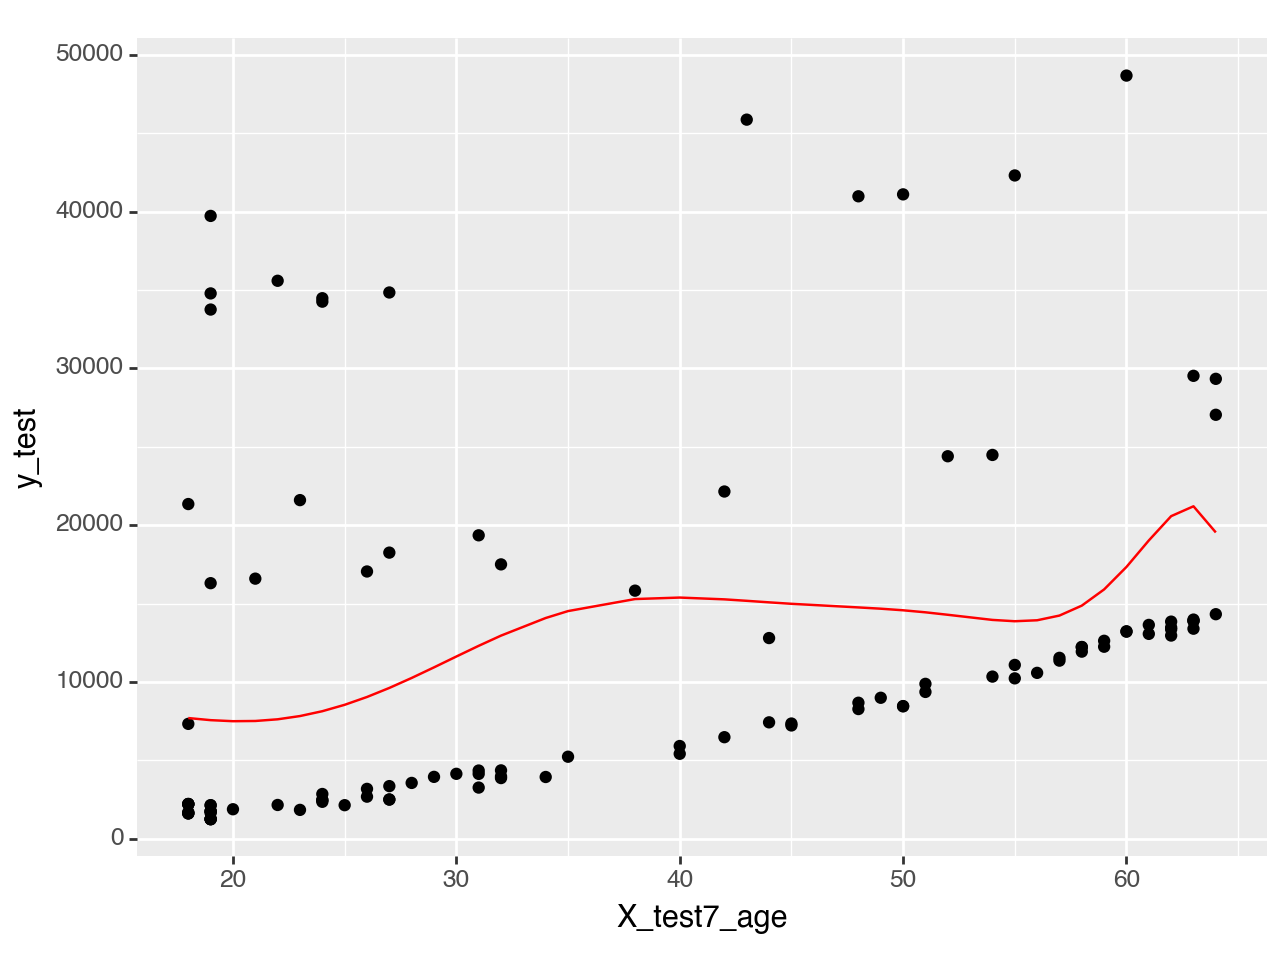

<Figure Size: (640 x 480)>

In [141]:
(ggplot(predictions_1, aes(x = "X_test7_age", y = "y_test"))
 + geom_point()
 + geom_line(aes(y = "y_preds7"), color = "red"))

# Part 4: New Data

In [142]:
new_insurance = pd.read_csv("https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1")
new_insurance

,age,sex,bmi,smoker,region,charges
0,23,male,34.400,no,southwest,1826.84300
1,56,male,40.300,no,southwest,10602.38500
2,18,male,34.100,no,southeast,1137.01100
3,63,female,23.085,no,northeast,14451.83515
4,63,male,28.310,no,northwest,13770.09790
...,...,...,...,...,...,...
138,19,male,34.900,yes,southwest,34828.65400
139,45,male,30.360,yes,southeast,62592.87309
140,43,male,27.800,yes,southwest,37829.72420
141,24,female,27.720,no,southeast,2464.61880


### Age as predictor only

In [143]:
#fit model on original data
X = insurance[["age"]] 
y = insurance["charges"] 

lr = LinearRegression() 

my_pipeline = Pipeline(
    [('ols', lr)] 
) 

my_pipeline_fitted = my_pipeline.fit(X, y)

#predict with new data
X_new = new_insurance[["age"]]
y_predict = my_pipeline_fitted.predict(X_new)

In [144]:
#MSE of new predicted data
mse_1 = mean_squared_error(new_insurance["charges"], y_predict)
mse_1

136077136.50195494

### Age and BMI

In [145]:
#fit model on original data
X_2 = insurance[["age", "bmi"]] 
y_2 = insurance["charges"] 

my_pipeline = Pipeline(
    [('ols', lr)] 
) 

my_pipeline_fitted2 = my_pipeline.fit(X_2, y_2)

#predict with new data
X_new2 = new_insurance[["age", "bmi"]]
y_predict2 = my_pipeline_fitted2.predict(X_new2)

In [146]:
#MSE of new predicted data
mse_2 = mean_squared_error(new_insurance["charges"], y_predict2)
mse_2

132636406.1108129

### Age, bmi, and smoker

In [147]:
#fit model on original data
X_3 = insurance[["age", "bmi", "smoker"]] 
y_3 = insurance["charges"] 

enc = OneHotEncoder()
lr = LinearRegression()

ct = ColumnTransformer(
    [("dummify", enc, ["smoker"])]
)

my_pipeline_dummy = Pipeline(
    [("dummify_everything", ct), ('ols', lr)] 
) 

my_pipeline_fitted3 = my_pipeline_dummy.fit(X_3, y_3)

# #predict with new data
X_new3 = new_insurance[["age", "bmi", "smoker"]]
y_predict3 = my_pipeline_fitted3.predict(X_new3)

In [148]:
mse_3 = mean_squared_error(new_insurance["charges"], y_predict3)
mse_3

64246084.01184816

### (Age + bmi):smoker

In [149]:
#first dummify smoker and sex
insurance_dummy = pd.get_dummies(insurance, columns = ["sex", "smoker"])
insurance_dummy

,age,bmi,region,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,southwest,16884.92400,1,0,0,1
1,33,22.705,northwest,21984.47061,0,1,1,0
2,32,28.880,northwest,3866.85520,0,1,1,0
3,31,25.740,southeast,3756.62160,1,0,1,0
4,60,25.840,northwest,28923.13692,1,0,1,0
...,...,...,...,...,...,...,...,...
426,23,33.400,southwest,10795.93733,1,0,1,0
427,18,31.920,northeast,2205.98080,1,0,1,0
428,18,36.850,southeast,1629.83350,1,0,1,0
429,21,25.800,southwest,2007.94500,1,0,1,0


In [150]:
#interaction between age and smoker; bmi and smoker
insurance_dummy["age_smoker_no"] = insurance_dummy["age"] * insurance_dummy["smoker_no"]
insurance_dummy["age_smoker_yes"] = insurance_dummy["age"] * insurance_dummy["smoker_yes"]
insurance_dummy["bmi_smoker_no"] = insurance_dummy["bmi"] * insurance_dummy["smoker_no"]
insurance_dummy["bmi_smoker_yes"] = insurance_dummy["bmi"] * insurance_dummy["smoker_yes"]
insurance_dummy

,age,bmi,region,charges,sex_female,sex_male,smoker_no,smoker_yes,age_smoker_no,age_smoker_yes,bmi_smoker_no,bmi_smoker_yes
0,19,27.900,southwest,16884.92400,1,0,0,1,0,19,0.000,27.90
1,33,22.705,northwest,21984.47061,0,1,1,0,33,0,22.705,0.00
2,32,28.880,northwest,3866.85520,0,1,1,0,32,0,28.880,0.00
3,31,25.740,southeast,3756.62160,1,0,1,0,31,0,25.740,0.00
4,60,25.840,northwest,28923.13692,1,0,1,0,60,0,25.840,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
426,23,33.400,southwest,10795.93733,1,0,1,0,23,0,33.400,0.00
427,18,31.920,northeast,2205.98080,1,0,1,0,18,0,31.920,0.00
428,18,36.850,southeast,1629.83350,1,0,1,0,18,0,36.850,0.00
429,21,25.800,southwest,2007.94500,1,0,1,0,21,0,25.800,0.00


In [151]:
#fit model to original data
X_4 = insurance_dummy[["age_smoker_yes", "bmi_smoker_yes"]]
y_4 = insurance_dummy["charges"]

lr = LinearRegression()

my_pipeline = Pipeline(
    [('ols', lr)] 
) 

my_pipeline_fitted4 = my_pipeline.fit(X_4, y_4)

In [152]:
#dummify new insurance data as well, and do interactions
new_insurance_dummy = pd.get_dummies(new_insurance, columns = ["sex", "smoker"])

#interaction between age and smoker; bmi and smoker
new_insurance_dummy["age_smoker_no"] = new_insurance_dummy["age"] * new_insurance_dummy["smoker_no"]
new_insurance_dummy["age_smoker_yes"] = new_insurance_dummy["age"] * new_insurance_dummy["smoker_yes"]
new_insurance_dummy["bmi_smoker_no"] = new_insurance_dummy["bmi"] * new_insurance_dummy["smoker_no"]
new_insurance_dummy["bmi_smoker_yes"] = new_insurance_dummy["bmi"] * new_insurance_dummy["smoker_yes"]
new_insurance_dummy

,age,bmi,region,charges,sex_female,sex_male,smoker_no,smoker_yes,age_smoker_no,age_smoker_yes,bmi_smoker_no,bmi_smoker_yes
0,23,34.400,southwest,1826.84300,0,1,1,0,23,0,34.400,0.00
1,56,40.300,southwest,10602.38500,0,1,1,0,56,0,40.300,0.00
2,18,34.100,southeast,1137.01100,0,1,1,0,18,0,34.100,0.00
3,63,23.085,northeast,14451.83515,1,0,1,0,63,0,23.085,0.00
4,63,28.310,northwest,13770.09790,0,1,1,0,63,0,28.310,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
138,19,34.900,southwest,34828.65400,0,1,0,1,0,19,0.000,34.90
139,45,30.360,southeast,62592.87309,0,1,0,1,0,45,0.000,30.36
140,43,27.800,southwest,37829.72420,0,1,0,1,0,43,0.000,27.80
141,24,27.720,southeast,2464.61880,1,0,1,0,24,0,27.720,0.00


In [153]:
#predict with new data
X_new4 = new_insurance_dummy[["age_smoker_yes", "bmi_smoker_yes"]]
y_predict4 = my_pipeline_fitted4.predict(X_new4)

In [154]:
#Mean square error
mse_4 = mean_squared_error(new_insurance_dummy["charges"], y_predict4)
mse_4

47626025.35814418

### (Age + bmi)*smoker

In [155]:
#predictor variables are age, bmi, smoker, age*smoker, bmi*smoker
#make sure to drop a dummy variable to have a "reference"

X_5 = insurance_dummy[["age", "bmi", "smoker_yes", "age_smoker_yes", "bmi_smoker_yes"]]
y_5 = insurance_dummy["charges"]

lr = LinearRegression()

my_pipeline = Pipeline(
    [('ols', lr)] 
) 

my_pipeline_fitted5 = my_pipeline.fit(X_5, y_5)

In [156]:
X_new5 = new_insurance_dummy[["age", "bmi", "smoker_yes", "age_smoker_yes", "bmi_smoker_yes"]]
y_predict5 = my_pipeline_fitted5.predict(X_new5)

In [157]:
mse_5 = mean_squared_error(new_insurance_dummy["charges"], y_predict5)
mse_5

21786256.86685256

In [176]:
#R2 score
r2_score(new_insurance_dummy["charges"], y_predict5)

0.8594886795699617

In [158]:
#combine all of the mean square errors

model_num = [1, 2, 3, 4, 5]
mse_list = [mse_1, mse_2, mse_3, mse_4, mse_5]

df_mse = pd.DataFrame({"model number": model_num,
                      "mse": mse_list})
df_mse.sort_values(by = "mse", ascending = True)


,model number,mse
4,5,2.178626e+07
3,4,4.762603e+07
2,3,6.424608e+07
1,2,1.326364e+08
0,1,1.360771e+08


Looking at the table created above, the mean squared error for model 5 is the smallest. This means that model 5 is the best model to use.

### Plot of residuals for Model 5 (age+bmi)*smoker

In [159]:
#residuals = actual - predicted
y_actual = new_insurance_dummy["charges"]
residuals = y_actual - y_predict5
residuals

0      -1771.030351
1      -1547.051734
2      -1168.355140
3        587.432573
4       -122.316796
           ...     
138     1798.448684
139    29922.612042
140     9456.425281
141    -1355.621700
142    -1243.926527
Name: charges, Length: 143, dtype: float64

In [160]:
#data frame of actual, predicted and residual values
residual_df = pd.DataFrame({"y_actual": y_actual,
                            "y_predicted": y_predict5,
                            "residuals": residuals})

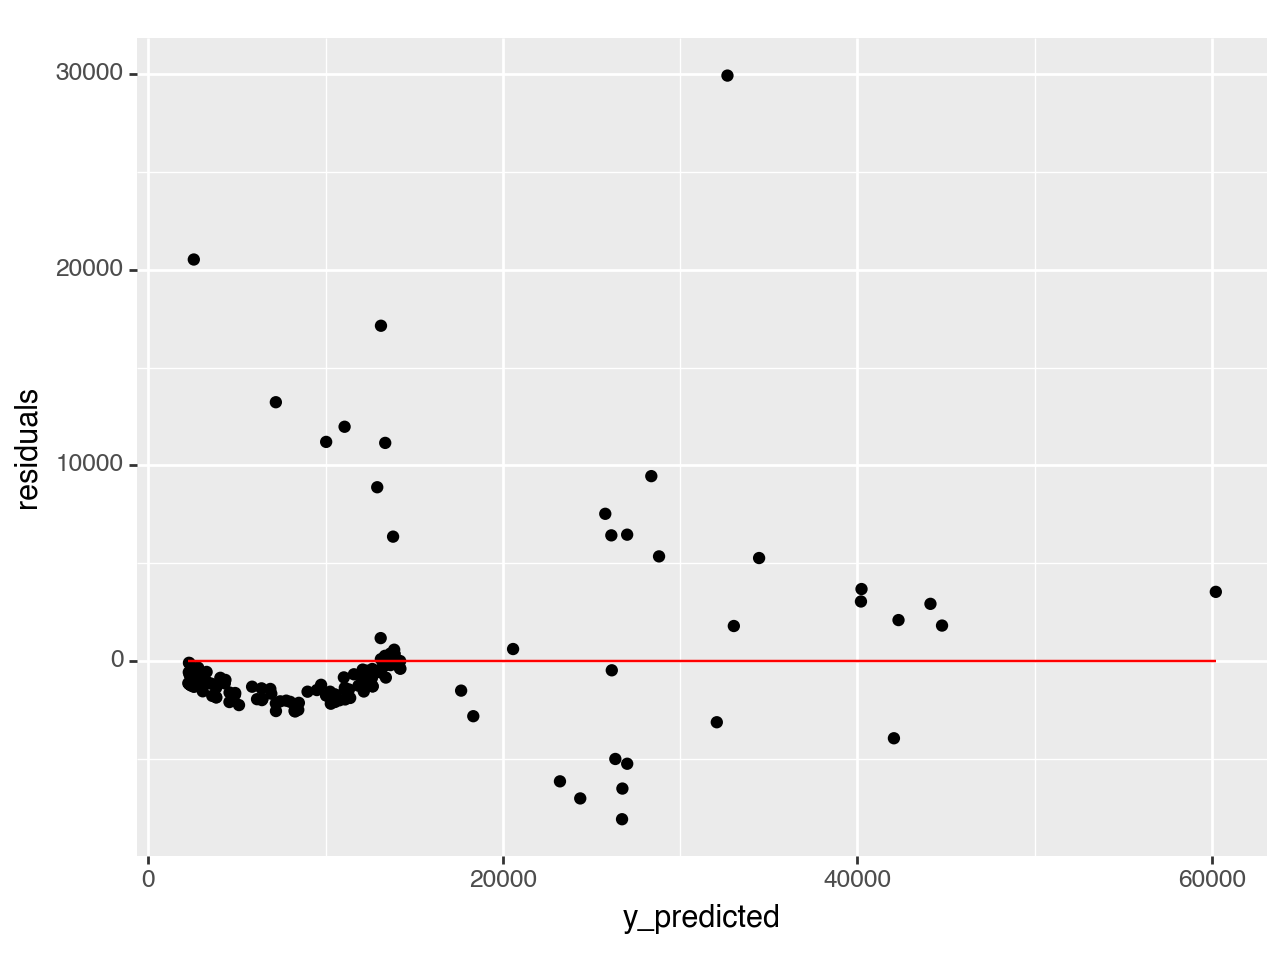

<Figure Size: (640 x 480)>

In [161]:
#plot of residuals (x = predicted, y = residuals)
(ggplot(residual_df, aes(x = "y_predicted", y = "residuals"))
 + geom_point()
 + geom_line(aes(y = 0), color = "red")
)

# Data Exploration

In [175]:
#interactions: age and bmi
insurance_dummy["age_bmi"] = insurance_dummy["age"] * insurance_dummy["bmi"]
insurance_dummy

,age,bmi,region,charges,sex_female,sex_male,smoker_no,smoker_yes,age_smoker_no,age_smoker_yes,bmi_smoker_no,bmi_smoker_yes,age_bmi
0,19,27.900,southwest,16884.92400,1,0,0,1,0,19,0.000,27.90,530.100
1,33,22.705,northwest,21984.47061,0,1,1,0,33,0,22.705,0.00,749.265
2,32,28.880,northwest,3866.85520,0,1,1,0,32,0,28.880,0.00,924.160
3,31,25.740,southeast,3756.62160,1,0,1,0,31,0,25.740,0.00,797.940
4,60,25.840,northwest,28923.13692,1,0,1,0,60,0,25.840,0.00,1550.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,23,33.400,southwest,10795.93733,1,0,1,0,23,0,33.400,0.00,768.200
427,18,31.920,northeast,2205.98080,1,0,1,0,18,0,31.920,0.00,574.560
428,18,36.850,southeast,1629.83350,1,0,1,0,18,0,36.850,0.00,663.300
429,21,25.800,southwest,2007.94500,1,0,1,0,21,0,25.800,0.00,541.800


In [164]:
#adding age_bmi and age^2 and bmi^2
X_ex = insurance_dummy[["age", "bmi", "age_bmi", "smoker_yes", "age_smoker_yes", "bmi_smoker_yes"]]
y_ex = insurance_dummy["charges"]

lr = LinearRegression()
poly2 = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False) 
poly_sex_smoker = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
# have interaction age^2, bmi^2 and age*bmi (all possible combinations), if it's true, then only age*bmi

ct2 = ColumnTransformer(
    [("quadratic", poly2, ["age", "bmi"])],
    remainder='passthrough' #tells it to not drop any columns not used
)

my_pipeline = Pipeline(
    [("squaring", ct2), ('ols', lr)] 
) 

my_pipeline_fitted_ex = my_pipeline.fit(X_ex, y_ex)

In [165]:
#predict with new_insurance_dummy

new_insurance_dummy["age_bmi"] = new_insurance_dummy["bmi"] * new_insurance_dummy["age"]

X_new_ex = new_insurance_dummy[["age", "bmi", "age_bmi", "smoker_yes", "age_smoker_yes", "bmi_smoker_yes"]]
y_predict_ex = my_pipeline_fitted_ex.predict(X_new_ex)

In [166]:
mse_ex = mean_squared_error(new_insurance_dummy["charges"], y_predict_ex)
mse_ex

21532023.68048704

In [167]:
r2_score(new_insurance_dummy["charges"], y_predict_ex)

0.8611283665034113

### Residual Plot - Data Exploration

In [168]:
y_actual_ex = new_insurance_dummy["charges"]
residual_ex = y_actual_ex - y_predict_ex

residual_df_ex = pd.DataFrame({"y_actual": y_actual_ex,
                            "y_predicted": y_predict_ex,
                            "residuals": residual_ex})
residual_df_ex

,y_actual,y_predicted,residuals
0,1826.84300,3718.536777,-1891.693777
1,10602.38500,11868.131768,-1265.746768
2,1137.01100,2706.201301,-1569.190301
3,14451.83515,14009.928050,441.907100
4,13770.09790,14460.588865,-690.490965
...,...,...,...
138,34828.65400,33416.107218,1412.546782
139,62592.87309,32552.508293,30040.364797
140,37829.72420,28138.186955,9691.537245
141,2464.61880,3990.461808,-1525.843008


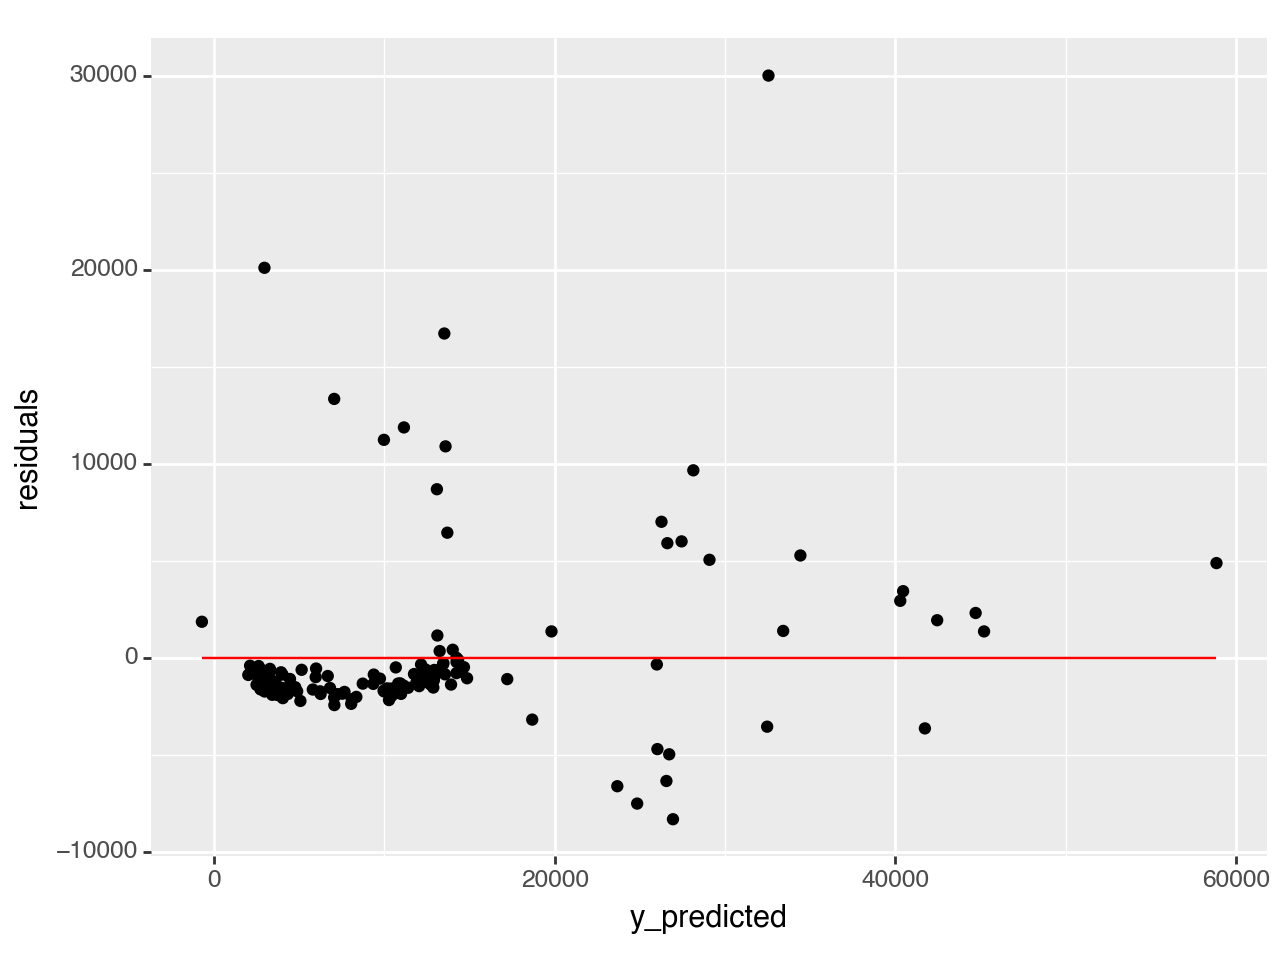

<Figure Size: (640 x 480)>

In [169]:
(ggplot(residual_df_ex, aes(x = "y_predicted", y = "residuals"))
 + geom_point()
 + geom_line(aes(y = 0), color = "red")
)